In [1]:
%load_ext autotime

time: 294 µs (started: 2021-11-04 19:41:53 +00:00)


## Imports

In [2]:
# for data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
import json

import requests
from requests.auth import HTTPBasicAuth
from elasticsearch import Elasticsearch, helpers
from elasticsearch_dsl import Search, Q

time: 1.33 s (started: 2021-11-04 19:42:04 +00:00)


In [3]:
# ignore warnings
# only for format's sake. Mainly future deprecation warnings, they have been heeded when necessary
import warnings
warnings.filterwarnings("ignore")

time: 551 µs (started: 2021-11-04 19:42:07 +00:00)


## 1. EDA

### a. Load data

In [4]:
# import data into pandas dataframe
companies_df = pd.read_csv("test_dataset.csv.gz")

time: 143 ms (started: 2021-11-04 19:42:10 +00:00)


In [5]:
companies_df.head(3)

,siren,siret,denominationUniteLegale,sigleUniteLegale,enseigne1Etablissement,activitePrincipaleEtablissement,geo_adresse,geo_score,categorieJuridiqueUniteLegale,codeCommuneEtablissement,dep
0,528342587,52834258700037,SYCORAX,NaN,NaN,70.22Z,12 La Marche 23220 Mortroux,0.94,5499.0,23136,23
1,829106806,82910680600013,TRAD'FUSE,NaN,NaN,90.01Z,22 Rue des Mayades 23500 Felletin,0.95,9220.0,23079,23
2,444608442,44460844214191,ENEDIS,NaN,NaN,35.13Z,13 La Cote Ribiere 23200 Moutier-Rozeille,0.89,5699.0,23140,23


time: 21.4 ms (started: 2021-11-04 19:42:11 +00:00)


### b. Explore and clean data

In [6]:
companies_df.shape

(42302, 11)

time: 3.3 ms (started: 2021-11-04 19:42:14 +00:00)


In [7]:
companies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42302 entries, 0 to 42301
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   siren                            42302 non-null  int64  
 1   siret                            42302 non-null  int64  
 2   denominationUniteLegale          42301 non-null  object 
 3   sigleUniteLegale                 4075 non-null   object 
 4   enseigne1Etablissement           6888 non-null   object 
 5   activitePrincipaleEtablissement  42301 non-null  object 
 6   geo_adresse                      37824 non-null  object 
 7   geo_score                        42302 non-null  float64
 8   categorieJuridiqueUniteLegale    42301 non-null  float64
 9   codeCommuneEtablissement         42302 non-null  int64  
 10  dep                              42302 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 3.6+ MB
time: 36.4 ms (started:

In [8]:
# cast columns to object type (or category for better memory management)
for col in ['siren', 'siret', 'codeCommuneEtablissement', 'categorieJuridiqueUniteLegale', 'dep']:
    companies_df[col] = companies_df[col].astype('object')

time: 14.8 ms (started: 2021-11-04 19:42:19 +00:00)


In [9]:
# category columns description
companies_df.describe(include='object')

,siren,siret,denominationUniteLegale,sigleUniteLegale,enseigne1Etablissement,activitePrincipaleEtablissement,geo_adresse,categorieJuridiqueUniteLegale,codeCommuneEtablissement,dep
count,42302,42302,42301,4075,6888,42301,37824,42301.0,42302,42302
unique,31517,42302,30235,1958,3717,1259,14484,179.0,444,2
top,356000745,52834258700037,LA POSTE,CACF,MAIRIE,68.20B,Hôtel de Ville Lille,5499.0,48095,23
freq,194,1,431,76,467,5254,550,9511.0,3895,23294


time: 186 ms (started: 2021-11-04 19:42:19 +00:00)


In [12]:
companies_df.loc[companies_df['geo_adresse']=='Hôtel de Ville Lille'].head(5)

,siren,siret,denominationUniteLegale,sigleUniteLegale,enseigne1Etablissement,activitePrincipaleEtablissement,geo_adresse,geo_score,categorieJuridiqueUniteLegale,codeCommuneEtablissement,dep
32,274800416,27480041600019,SERVICE DES EAUX DE GATUZIERES,NaN,NaN,41.0Z,Hôtel de Ville Lille,0.92,7510.0,48069,48
40,777987363,77798736300010,CUMA DU TUTET,NaN,NaN,01.61Z,Hôtel de Ville Lille,0.92,6316.0,23064,23
45,820734531,82073453100016,SOCIETE COMMUNALE DE CHASSE D'AUROUX,NaN,NaN,93.19Z,Hôtel de Ville Lille,0.92,9220.0,48010,48
194,264801135,26480113500015,CENTRE COMMUNAL D'ACTION SOCIALE,NaN,CCAS DE MOLEZON,88.99B,Hôtel de Ville Lille,0.92,7361.0,48098,48
399,214800153,21480015300063,COMMUNE DE PIED-DE-BORNE,NaN,ATELIER DE CHATAIGNE,68.20B,Hôtel de Ville Lille,0.92,7210.0,48015,48


time: 23.9 ms (started: 2021-11-04 19:42:30 +00:00)


* The `Hôtel de ville Lille` adress seems to come up quite a lot. I could not find the adresses online and it seems to be a data quality issue. (To be investigated).

In [13]:
# look for missing data
companies_df.isnull().sum()

siren                                  0
siret                                  0
denominationUniteLegale                1
sigleUniteLegale                   38227
enseigne1Etablissement             35414
activitePrincipaleEtablissement        1
geo_adresse                         4478
geo_score                              0
categorieJuridiqueUniteLegale          1
codeCommuneEtablissement               0
dep                                    0
dtype: int64

time: 43.6 ms (started: 2021-11-04 19:42:33 +00:00)


In [14]:
companies_df.loc[companies_df['denominationUniteLegale'].isnull()]

,siren,siret,denominationUniteLegale,sigleUniteLegale,enseigne1Etablissement,activitePrincipaleEtablissement,geo_adresse,geo_score,categorieJuridiqueUniteLegale,codeCommuneEtablissement,dep
40575,497963736,49796373600010,NaN,NaN,NaN,41.20A,Rue des Combettes Planes 48170 Châteauneuf-de-...,0.84,NaN,48043,48


time: 20.5 ms (started: 2021-11-04 19:42:36 +00:00)


In [15]:
companies_df[companies_df['siren']==497963736]

,siren,siret,denominationUniteLegale,sigleUniteLegale,enseigne1Etablissement,activitePrincipaleEtablissement,geo_adresse,geo_score,categorieJuridiqueUniteLegale,codeCommuneEtablissement,dep
40575,497963736,49796373600010,NaN,NaN,NaN,41.20A,Rue des Combettes Planes 48170 Châteauneuf-de-...,0.84,NaN,48043,48


time: 19.8 ms (started: 2021-11-04 19:42:36 +00:00)


* This one row has all the three missing values for **'categorieJuridiqueUniteLegal'**, **'denominationUniteLegale'** and **'activitePrincipaleEtablissement'**. And we could not find a row which contains data relating to the same company.

<AxesSubplot:ylabel='None'>

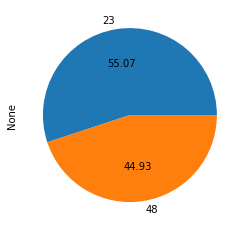

time: 135 ms (started: 2021-11-04 19:42:39 +00:00)


In [16]:
# departement percentage
companies_df.groupby('dep').size().plot(kind='pie', autopct='%.2f')

In [17]:
# 10 most frequent companies siren numbers
companies_df['siren'].value_counts().to_frame()[:10]

,siren
356000745,194
356000000,119
356000919,118
501542021,66
552049447,60
750401176,56
262324700,50
495105918,48
538160656,43
527809339,41


time: 36.2 ms (started: 2021-11-04 19:42:40 +00:00)


In [18]:
# add column with siren frequency
companies_df['frequenceEtablissement'] = companies_df['siren'].map(companies_df['siren'].value_counts())
companies_df.sort_values(by=['frequenceEtablissement'], inplace=True, ascending=False)

time: 59.8 ms (started: 2021-11-04 19:42:42 +00:00)


<AxesSubplot:ylabel='None'>

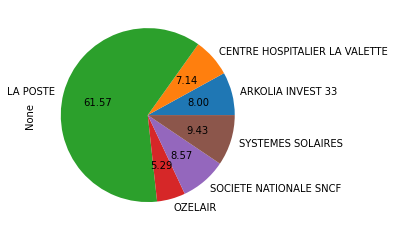

time: 136 ms (started: 2021-11-04 19:42:42 +00:00)


In [19]:
# company frequency
companies_df[:700].groupby('denominationUniteLegale').size().plot(kind='pie', autopct='%.2f')

* `La poste` seems to be a winner!

In [20]:
# drop added frequency column
companies_df.drop(columns='frequenceEtablissement', inplace=True)

time: 12.1 ms (started: 2021-11-04 19:42:51 +00:00)


* ###### Elasticsearch does not like missing data, and the `null_value` parameter cannot be used with a `text` field. Consequently, the missing data has to be delt with before ingestion. We chose to replace the missing data with a `Non renseigné` string.

In [21]:
# replace missing values
companies_df.fillna("Non renseigne", inplace=True)

time: 103 ms (started: 2021-11-04 19:42:53 +00:00)


In [22]:
companies_df.isnull().sum()

siren                              0
siret                              0
denominationUniteLegale            0
sigleUniteLegale                   0
enseigne1Etablissement             0
activitePrincipaleEtablissement    0
geo_adresse                        0
geo_score                          0
categorieJuridiqueUniteLegale      0
codeCommuneEtablissement           0
dep                                0
dtype: int64

time: 36.3 ms (started: 2021-11-04 19:42:54 +00:00)


In [23]:
# let's look for duplicates
duplicate_rows_df = companies_df[companies_df.duplicated()]
duplicate_rows_df.shape

(0, 11)

time: 64.7 ms (started: 2021-11-04 19:42:54 +00:00)


* ##### There are no duplicates!

### c. Split data

* We can filter on the `dep` directly when ingesting data. But we prefer to keep the dataframes in memory for possible use later on.

In [24]:
companies_creuse = companies_df.loc[companies_df['dep']==23]
companies_creuse.shape

(23294, 11)

time: 8.3 ms (started: 2021-11-04 19:42:57 +00:00)


In [25]:
companies_lozere=companies_df.loc[companies_df['dep']==48]
companies_lozere.shape

(19008, 11)

time: 7.25 ms (started: 2021-11-04 19:42:57 +00:00)


## 2. Elasticsearch

Warning: If not using a jupyter docker container, substitue `host.docker.internal`with `localhost`in all URLs.

### a. Check Elasticsearch

In [31]:
# make sure ES is up and running
response = requests.get('http://host.docker.internal:9200', auth=HTTPBasicAuth('elastic', 'elastic'))

time: 15 ms (started: 2021-11-04 19:45:49 +00:00)


In [32]:
json_data = json.loads(response.content)
pprint(json_data)

{'cluster_name': 'es-docker-cluster',
 'cluster_uuid': 'VOPJ8ZmdR3-kiUTAtf13aA',
 'name': 'elastic-sirene',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2021-04-20T20:56:39.040728659Z',
             'build_flavor': 'default',
             'build_hash': '3186837139b9c6b6d23c3200870651f10d3343b7',
             'build_snapshot': False,
             'build_type': 'docker',
             'lucene_version': '8.8.0',
             'minimum_index_compatibility_version': '6.0.0-beta1',
             'minimum_wire_compatibility_version': '6.8.0',
             'number': '7.12.1'}}
time: 5.14 ms (started: 2021-11-04 19:45:51 +00:00)


Yay! it works :)

### b. Instantiate a client instance

In [33]:
# connect to ES server using the elasticsearch-py library
elastic_client = Elasticsearch([{'host': 'host.docker.internal', 'port': 9200}], http_auth=("elastic", "elastic"))

time: 866 µs (started: 2021-11-04 19:45:59 +00:00)


In [34]:
elastic_client.info()

{'name': 'elastic-sirene',
 'cluster_name': 'es-docker-cluster',
 'cluster_uuid': 'VOPJ8ZmdR3-kiUTAtf13aA',
 'version': {'number': '7.12.1',
  'build_flavor': 'default',
  'build_type': 'docker',
  'build_hash': '3186837139b9c6b6d23c3200870651f10d3343b7',
  'build_date': '2021-04-20T20:56:39.040728659Z',
  'build_snapshot': False,
  'lucene_version': '8.8.0',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

time: 20.8 ms (started: 2021-11-04 19:46:00 +00:00)


### c. Ingest data

#### i. Create indices

In [36]:
# returns a list of all the cluster's indices
all_indices = elastic_client.indices.get_alias()
all_indices

{}

time: 13.1 ms (started: 2021-11-04 19:48:00 +00:00)


In [35]:
# delete indices
# elastic_client.indices.delete(index='creuse_index')
# elastic_client.indices.delete(index='lozere_index')

{'acknowledged': True}

time: 125 ms (started: 2021-11-04 19:47:54 +00:00)


* We chose static mapping instead of dynamic mapping to have absolute control over the fields.

Mapping schema:
- **siren**: *keyword* (becuase it's structured content i.e ID)
- **siret**: *keyword* (becuase it's structured content i.e ID)
- **denominationUniteLegale**: *text*
- **sigleUniteLegale**: *text*
- **enseigne1Etablissement**: *text*
- **activitePrincipaleEtablissement**: *text*
- **geo_adresse**: *text*
- **geo_score**: *float*
- **categorieJuridiqueUniteLegale**: *text*
- **codeCommuneEtablissement**: *integer*
- **dep**: *constant keyword* (because it contains the same value)

In [37]:
mapping = {
  "settings": { "number_of_shards": 1 },
  "mappings": {
      "properties" : {
        "siren" : {
          "type" :    "keyword"
        },
        "siret" : {
          "type" :    "keyword"
        },
        "denominationUniteLegale" : {
          "type" :   "text"
        },
        "sigleUniteLegale" : {
          "type" :   "text"
        },
        "enseigne1Etablissement" : {
          "type" :   "text"
        },
        "activitePrincipaleEtablissement" : {
          "type" :   "text"
        },
        "geo_adresse" : {
          "type" :   "text"
        },
        "geo_score" : {
          "type" :   "float"
        },
        "categorieJuridiqueUniteLegale" : {
          "type" :   "text"
        },
        "codeCommuneEtablissement" : {
          "type" :   "integer"
        },
        "dep" : {
          "type" :   "constant_keyword"
        }
      }
  }
}

time: 926 µs (started: 2021-11-04 19:48:15 +00:00)


In [38]:
# create Creuse index
elastic_client.indices.create(index='creuse_index', body=mapping)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'creuse_index'}

time: 162 ms (started: 2021-11-04 19:48:19 +00:00)


In [39]:
# create Lozere index
elastic_client.indices.create(index='lozere_index', body=mapping)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'lozere_index'}

time: 125 ms (started: 2021-11-04 19:48:19 +00:00)


In [40]:
# returns a list of all the cluster's indices
elastic_client.indices.get_alias()

{'lozere_index': {'aliases': {}}, 'creuse_index': {'aliases': {}}}

time: 12.4 ms (started: 2021-11-04 19:48:20 +00:00)


#### ii. Ingest dataframes into indices

* We do so using [`helpers.bulk`](https://elasticsearch-py.readthedocs.io/en/7.9.1/helpers.html) which requires a generator, which means indexing the dataset without putting it into memory, which in turn saves resources.

* Let's start by converting every row in the dataframe into a document to ingest into elasticsearch index:

In [41]:
# generator loops over every row of the dataframe and converts it into an index and a document(dictionary) to ingest into an ES index
def doc_generator(df, elastic_index):
    df_iter = df.iterrows()
    for index, document in df_iter:
        yield {
                "_index": elastic_index,
                "_id" : index,
                "_source": document.to_dict(),
            }

time: 695 µs (started: 2021-11-04 19:48:26 +00:00)


In [42]:
# ingest creuse (23) dataframe into creuse_index using the helpers.bulk method 
helpers.bulk(elastic_client, doc_generator(companies_creuse, 'creuse_index')) # request_timeout=20 for network latency

(23294, [])

time: 5.4 s (started: 2021-11-04 19:48:32 +00:00)


In [43]:
request_creuse = requests.get('http://host.docker.internal:9200/creuse_index?pretty', auth=HTTPBasicAuth('elastic', 'elastic'))

time: 29.1 ms (started: 2021-11-04 19:48:38 +00:00)


In [44]:
pprint(json.loads(request_creuse.content))

{'creuse_index': {'aliases': {},
                  'mappings': {'properties': {'activitePrincipaleEtablissement': {'type': 'text'},
                                              'categorieJuridiqueUniteLegale': {'type': 'text'},
                                              'codeCommuneEtablissement': {'type': 'integer'},
                                              'denominationUniteLegale': {'type': 'text'},
                                              'dep': {'type': 'constant_keyword',
                                                      'value': '23'},
                                              'enseigne1Etablissement': {'type': 'text'},
                                              'geo_adresse': {'type': 'text'},
                                              'geo_score': {'type': 'float'},
                                              'sigleUniteLegale': {'type': 'text'},
                                              'siren': {'type': 'keyword'},
                          

In [46]:
# to get the index mapping
pprint(elastic_client.indices.get_mapping(index='creuse_index'))

{'creuse_index': {'mappings': {'properties': {'activitePrincipaleEtablissement': {'type': 'text'},
                                              'categorieJuridiqueUniteLegale': {'type': 'text'},
                                              'codeCommuneEtablissement': {'type': 'integer'},
                                              'denominationUniteLegale': {'type': 'text'},
                                              'dep': {'type': 'constant_keyword',
                                                      'value': '23'},
                                              'enseigne1Etablissement': {'type': 'text'},
                                              'geo_adresse': {'type': 'text'},
                                              'geo_score': {'type': 'float'},
                                              'sigleUniteLegale': {'type': 'text'},
                                              'siren': {'type': 'keyword'},
                                              'siret': {'ty

In [47]:
# check if the data was rightly indexed
elastic_client.get(index='creuse_index', id=0)['_source']

{'siren': 528342587,
 'siret': 52834258700037,
 'denominationUniteLegale': 'SYCORAX',
 'sigleUniteLegale': 'Non renseigne',
 'enseigne1Etablissement': 'Non renseigne',
 'activitePrincipaleEtablissement': '70.22Z',
 'geo_adresse': '12 La Marche 23220 Mortroux',
 'geo_score': 0.94,
 'categorieJuridiqueUniteLegale': 5499.0,
 'codeCommuneEtablissement': 23136,
 'dep': 23}

time: 22.4 ms (started: 2021-11-04 19:54:01 +00:00)


In [48]:
# ingest lozere (48) dataframe into creuse index using the helpers.bulk method 
helpers.bulk(elastic_client, doc_generator(companies_lozere, 'lozere_index'))

(19008, [])

time: 3.67 s (started: 2021-11-04 19:54:09 +00:00)


In [49]:
request_lozere = requests.get('http://host.docker.internal:9200/lozere_index?pretty', auth=HTTPBasicAuth('elastic', 'elastic'))

time: 15.9 ms (started: 2021-11-04 19:54:14 +00:00)


In [50]:
pprint(json.loads(request_lozere.content))

{'lozere_index': {'aliases': {},
                  'mappings': {'properties': {'activitePrincipaleEtablissement': {'type': 'text'},
                                              'categorieJuridiqueUniteLegale': {'type': 'text'},
                                              'codeCommuneEtablissement': {'type': 'integer'},
                                              'denominationUniteLegale': {'type': 'text'},
                                              'dep': {'type': 'constant_keyword',
                                                      'value': '48'},
                                              'enseigne1Etablissement': {'type': 'text'},
                                              'geo_adresse': {'type': 'text'},
                                              'geo_score': {'type': 'float'},
                                              'sigleUniteLegale': {'type': 'text'},
                                              'siren': {'type': 'keyword'},
                          

In [60]:
# check if the data was rightly indexed
elastic_client.get(index='lozere_index', id=10)['_source']

{'siren': 903444479,
 'siret': 90344447900013,
 'denominationUniteLegale': 'BRICOMART',
 'sigleUniteLegale': 'Non renseigne',
 'enseigne1Etablissement': 'Non renseigne',
 'activitePrincipaleEtablissement': '47.52B',
 'geo_adresse': '21 Route de Mende 48400 Florac Trois Rivières',
 'geo_score': 0.83,
 'categorieJuridiqueUniteLegale': 5499.0,
 'codeCommuneEtablissement': 48061,
 'dep': 48}

time: 12 ms (started: 2021-11-04 19:55:35 +00:00)


In [61]:
# quick access to the document count
elastic_client.cat.count(index="creuse_index", params={"format": "json"})

[{'epoch': '1636055746', 'timestamp': '19:55:46', 'count': '23294'}]

time: 31.3 ms (started: 2021-11-04 19:55:46 +00:00)


In [62]:
# quick access to the document count
elastic_client.cat.count(index="lozere_index", params={"format": "json"})

[{'epoch': '1636055746', 'timestamp': '19:55:46', 'count': '19008'}]

time: 12 ms (started: 2021-11-04 19:55:46 +00:00)


### d. Search queries

* There are two ways we could go about this; either using the low-level API or the expressive DSL API. For the first question we will test both. As for the remaining questions, we will use the high level DSl library as it is more Pythonic and less verbose.

#### Question 1: All companies in Department 23 where denominationUniteLegale contains word : `boulanger`

#### i. Using the low level API

In [92]:
# Python dictionary object representing the Elasticsearch JSON query
search_query = {
    'query': {
        'wildcard': {
            'denominationUniteLegale': '*boulanger*'
        }
    }
}

time: 474 µs (started: 2021-11-04 20:06:17 +00:00)


In [93]:
question_1 = elastic_client.search(index="creuse_index", body=search_query, size=10000)
#_source=['siren']: to return only `siren` field
type(question_1)

dict

time: 23.3 ms (started: 2021-11-04 20:06:18 +00:00)


* The response is a `dict`

In [94]:
print(f"There are ** {question_1['hits']['total']['value']} ** hits for your query!")

There are ** 16 ** hits for your query!
time: 1.71 ms (started: 2021-11-04 20:06:20 +00:00)


In [95]:
# print siren and name fields
pprint([(i['_source']['siren'], i['_source']['denominationUniteLegale']) for i in question_1["hits"]["hits"]])

[(521552075,
  'AMICALE ANCIENS BOULANGERS ET BOULANGERS PATISSIERS DE CREUSE BOURDONNAIS '
  'COMBRAILLES'),
 (521552075,
  'AMICALE ANCIENS BOULANGERS ET BOULANGERS PATISSIERS DE CREUSE BOURDONNAIS '
  'COMBRAILLES'),
 (777998741, 'SYNDICAT DES PATRONS BOULANGER'),
 (478455793, 'BOULANGERIES BG'),
 (777998741, 'SYNDICAT DES PATRONS BOULANGER'),
 (377553706, 'POUGHEON BOULANGER PATISSIER'),
 (342592813, 'BOULANGER PATISSERIE EPICERIE LE GELDON'),
 (751721689, 'BOULANGERIE ESPAGNE'),
 (483613022, 'BOULANGERIE PATISSERIE DU SOLEIL'),
 (342466984, 'BOULANGERIE PATISSERIE DEVOUEZE'),
 (499646420, 'BOULANGERIE THIOLAS - DUPONT'),
 (301466520, 'BOULANGERIE PATISSERIE DU CHATEAU'),
 (330450164, 'EXPLOIT BOULANGER PATISSER MAISON FAURY'),
 (478695034, 'SOC EQUIPEMENTS BOULANGERIE PATISSERIE'),
 (512788126, 'BOULANGERIE JUBERT'),
 (326492139, 'BOULANGERIE MIRAUX')]
time: 6.17 ms (started: 2021-11-04 20:06:24 +00:00)


In [ ]:
# print all fields
pprint(question_1['hits']['hits'])

#### ii. Using Elasticsearch DSL library

In [97]:
search_1 = Search(using=elastic_client, index='creuse_index') \
                .query('wildcard', denominationUniteLegale='*boulanger*')\
                .extra(size=1000)

time: 733 µs (started: 2021-11-04 20:06:51 +00:00)


In [98]:
question_1_dsl = search_1.execute()
print('Total hits: {}\n'.format(question_1_dsl['hits']['total']['value']))

Total hits: 16

time: 23.3 ms (started: 2021-11-04 20:06:55 +00:00)


In [99]:
type(question_1_dsl)

elasticsearch_dsl.response.Response

time: 4.06 ms (started: 2021-11-04 20:06:56 +00:00)


* The reponse is a `reponse object`

In [136]:
# print siren, siret and name fields
pprint([(hit.siren, hit.siret, hit.denominationUniteLegale) for hit in question_1_dsl])

[(521552075,
  52155207500025,
  'AMICALE ANCIENS BOULANGERS ET BOULANGERS PATISSIERS DE CREUSE BOURDONNAIS '
  'COMBRAILLES'),
 (521552075,
  52155207500017,
  'AMICALE ANCIENS BOULANGERS ET BOULANGERS PATISSIERS DE CREUSE BOURDONNAIS '
  'COMBRAILLES'),
 (777998741, 77799874100022, 'SYNDICAT DES PATRONS BOULANGER'),
 (478455793, 47845579302756, 'BOULANGERIES BG'),
 (777998741, 77799874100014, 'SYNDICAT DES PATRONS BOULANGER'),
 (377553706, 37755370600013, 'POUGHEON BOULANGER PATISSIER'),
 (342592813, 34259281300014, 'BOULANGER PATISSERIE EPICERIE LE GELDON'),
 (751721689, 75172168900014, 'BOULANGERIE ESPAGNE'),
 (483613022, 48361302200019, 'BOULANGERIE PATISSERIE DU SOLEIL'),
 (342466984, 34246698400016, 'BOULANGERIE PATISSERIE DEVOUEZE'),
 (499646420, 49964642000012, 'BOULANGERIE THIOLAS - DUPONT'),
 (301466520, 30146652000014, 'BOULANGERIE PATISSERIE DU CHATEAU'),
 (330450164, 33045016400018, 'EXPLOIT BOULANGER PATISSER MAISON FAURY'),
 (478695034, 47869503400031, 'SOC EQUIPEMENTS 

In [ ]:
# to print all fields
pprint ([hit._d_ for hit in question_1_dsl])

#### iii. Test with Pandas to make sure the search results are correct

In [105]:
companies_creuse[companies_creuse['denominationUniteLegale'].str.contains('BOULANGER')].shape[0]

16

time: 20 ms (started: 2021-11-04 20:08:21 +00:00)


* The results seem to match!

#### Question 2: All companies in Department 48 where activitePrincipaleEtablissement is 90.01Z

In [106]:
# we use the `filter` context since we don't care about the score of matching documents, and it's faster than the 'query' context
search_2 = Search(using=elastic_client, index='lozere_index') \
                .filter('match', activitePrincipaleEtablissement='90.01Z')\
                .extra(size=1000)

time: 1.02 ms (started: 2021-11-04 20:08:54 +00:00)


In [109]:
question_2 = search_2.execute()
print('Total hits: {}\n'.format(question_2['hits']['total']['value']))

Total hits: 167

time: 970 µs (started: 2021-11-04 20:09:07 +00:00)


In [130]:
# print siren, siret and activity for matching companies
pprint([(hit.siren, hit.siret, hit.activitePrincipaleEtablissement) for hit in question_2])

[(214800617, 21480061700109, '90.01Z'),
 (390541191, 39054119100057, '90.01Z'),
 (451174023, 45117402300031, '90.01Z'),
 (443716121, 44371612100043, '90.01Z'),
 (451174023, 45117402300023, '90.01Z'),
 (498812981, 49881298100021, '90.01Z'),
 (498812981, 49881298100013, '90.01Z'),
 (430072488, 43007248800041, '90.01Z'),
 (498812981, 49881298100047, '90.01Z'),
 (451174023, 45117402300015, '90.01Z'),
 (498812981, 49881298100039, '90.01Z'),
 (443716121, 44371612100027, '90.01Z'),
 (451174023, 45117402300049, '90.01Z'),
 (443716121, 44371612100035, '90.01Z'),
 (383534815, 38353481500030, '90.01Z'),
 (200047710, 20004771000070, '90.01Z'),
 (447988569, 44798856900037, '90.01Z'),
 (522974575, 52297457500022, '90.01Z'),
 (808874671, 80887467100015, '90.01Z'),
 (418505624, 41850562400027, '90.01Z'),
 (802809830, 80280983000010, '90.01Z'),
 (535275911, 53527591100019, '90.01Z'),
 (493221006, 49322100600015, '90.01Z'),
 (798090791, 79809079100020, '90.01Z'),
 (808874671, 80887467100023, '90.01Z'),


In [ ]:
# to print all fields
pprint ([hit._d_ for hit in question_2])

#### Question 3: All companies in Department 23 where codeCommuneEtablissement is 23079 or 23176

In [115]:
search_3 = Search(using=elastic_client, index='creuse_index') \
                .filter('terms', codeCommuneEtablissement=['23079','23176'])\
                .extra(size=2000)

time: 813 µs (started: 2021-11-04 20:11:36 +00:00)


In [117]:
question_3 = search_3.execute()
print('Total hits: {}\n'.format(question_3['hits']['total']['value']))

Total hits: 1835

time: 997 µs (started: 2021-11-04 20:11:46 +00:00)


In [122]:
# list of siren, siret  and codeCommuneEtablissement numbers corresponding to the query
pprint([(hit.siren, hit.siret, hit.codeCommuneEtablissement) for hit in question_3])

[(356000745, 35600074505229, 23176),
 (356000745, 35600074501152, 23079),
 (356000745, 35600074507167, 23079),
 (356000745, 35600074503927, 23176),
 (356000745, 35600074507746, 23176),
 (356000745, 35600074505443, 23176),
 (356000745, 35600074502036, 23176),
 (356000745, 35600074505336, 23079),
 (356000000, 35600000001569, 23176),
 (356000000, 35600000001573, 23176),
 (356000000, 35600000001415, 23079),
 (501542021, 50154202100560, 23079),
 (552049447, 55204944746710, 23079),
 (552049447, 55204944748245, 23176),
 (552049447, 55204944747262, 23176),
 (262324700, 26232470000125, 23176),
 (262324700, 26232470000216, 23176),
 (262324700, 26232470000174, 23176),
 (262324700, 26232470000026, 23176),
 (538160656, 53816065602554, 23176),
 (527809339, 52780933901039, 23079),
 (172302119, 17230211900091, 23079),
 (172302119, 17230211900208, 23176),
 (399467505, 39946750500851, 23079),
 (399467505, 39946750501016, 23176),
 (552081317, 55208131780069, 23079),
 (445200488, 44520048802404, 23176),
 

In [ ]:
# to print all fields
for hit in question_3:
    pprint (hit._d_)

#### Question 4: Relevant companies in Departement 48 where terms of query is Théâtre Mende (NB : Mende is the city capital of Department 48)

In [153]:
# `Or` is the default operator for `query_string`
search_4 = Search(using=elastic_client, index='lozere_index') \
                .query('query_string', query='Théâtre Mende')\
                .extra(size=20)

time: 744 µs (started: 2021-11-04 20:23:57 +00:00)


* 20 most relevant results based on the Term Frequency/Inverse Document Frequency (TF/IDF) model
* If we use the `AND` operator, we get only 6 matches. The most relevant companies.

In [156]:
question_4 = search_4.execute()
print('Total hits: {}\n'.format(question_4['hits']['total']['value']))

Total hits: 3949

time: 874 µs (started: 2021-11-04 20:24:40 +00:00)


In [157]:
pprint([(hit.meta.score, hit.siren, hit.siret, hit.geo_adresse) for hit in question_4])

[(10.07526, 325445260, 32544526000038, 'Rue du Théâtre 48000 Mende'),
 (9.384995, 317442176, 31744217600770, '1 Rue du Théâtre 48000 Mende'),
 (9.384995, 775627391, 77562739102199, '1 Rue du Théâtre 48000 Mende'),
 (9.384995, 775688658, 77568865800746, '1 Rue du Théâtre 48000 Mende'),
 (9.384995, 423658475, 42365847500029, '7 Rue du Théâtre 48000 Mende'),
 (9.384995, 776115263, 77611526300035, '1 Rue du Théâtre 48000 Mende'),
 (8.826167, 805263142, 80526314200020, 'Avenue du 8 Mai 1945 48000 Mende'),
 (8.826167, 805263142, 80526314200012, 'Rue de Fontanilles 48000 Mende'),
 (8.386117, 853396992, 85339699200010, 'Théâtre des Quatre Saisons Gradignan'),
 (7.0839477,
  130005481,
  13000548120133,
  '44b Avenue du 11 Novembre 48000 Mende'),
 (7.0839477, 160022042, 16002204200636, '12 Avenue Maréchal Foch 48000 Mende'),
 (5.6914506,
  130014772,
  13001477200219,
  '1 Boulevard Lucien Arnault 48000 Mende'),
 (5.6914506, 130014772, 13001477200250, '2 Allée Paul Doumer 48000 Mende'),
 (5.691

In [ ]:
# print all fields
pprint ([hit._d_ for hit in question_4])

And voilà!